<a href="https://colab.research.google.com/github/pllus/attention_learning/blob/main/MultiHeadAttention_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

path = kagglehub.dataset_download("akash2907/bird-species-classification")

print("Path to dataset files:", path)

100%|██████████| 1.37G/1.37G [00:19<00:00, 74.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1


Note* ไม่ได้ clean data ไม่ได้ทำไรเลยเเค่ลอง Mha เฉยๆ อย่าถามหาประโยชเพราะมันไม่มี


Query Data with Attention from birb dataset


Multihead attention


In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from tqdm import trange
from tqdm import tqdm

from PIL import Image
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_path = '/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/blasti/DSC_6382.jpg'

In [ ]:
img_1 = path +'/train_data/train_data/indvul/DSC_0502.jpg'

In [ ]:
image = Image.open(img_1).convert("RGB")
image
#ชหเเล้วรูปอย่างใหญ่นกตัวนิดเดียว

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)), #4096
    transforms.ToTensor(),
])
#Resize มั่ว

In [ ]:
train_path = path + '/train_data/train_data/'
test_path = path + '/test_data/test_data/'

In [ ]:
image_paths = []
labels = []
label = 0
for dir in os.listdir(train_path):
  dir_path = os.path.join(train_path, dir)
  print(dir_path)


/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/indvul
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/lbicrw
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/himbul
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/cbrtsh
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/rebimg
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/hsparo
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/cmnmyn
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/hilpig
/root/.cache/kagglehub/datasets/akash2907/bird-species-classification/versions/1/train_data/train_data/blasti
/root/.cac

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, data_dir,transform):
      self.image_paths = []
      self.labels = []
      label = 0
      for fold in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, fold)
        for file in os.listdir(folder_path):
          if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, file)
            self.image_paths.append(img_path)
            self.labels.append(label)
        label += 1
      self.transform = transform
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        image = self.transform(image)

        return image, label

In [ ]:
train_dataset = BirdDataset(train_path,transform)
test_dataset = BirdDataset(test_path,transform)

In [ ]:
train_dataset.labels.index(label)

0

In [ ]:
train_dataset.labels.index(2)

15

100%|██████████| 16/16 [00:03<00:00,  4.45it/s]


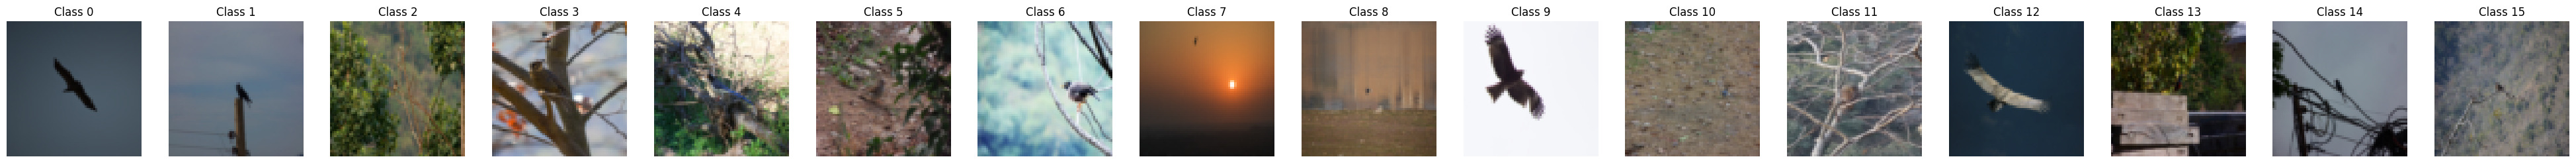

In [ ]:
fig, axes = plt.subplots(1,16, figsize=(50, 50))
for i in trange(16):
  index = train_dataset.labels.index(i)
  image,label = train_dataset[index]
  image = transforms.ToPILImage()(image)
  axes[i].imshow(image)
  axes[i].axis('off')
  axes[i].set_title(f"Class {label}")
plt.show()

Multi head attention
[link text](https://pytorch.org/docs/2.1/generated/torch.nn.MultiheadAttention.html#torch.nn.MultiheadAttention)

Similarity Seach Using Mha


In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
len(train_dataset)

150

In [ ]:
data_set = []

for i in trange(len(train_dataset)):
    image, labels = train_dataset[i]
    flattened = image.reshape(1, -1) #flatten 1, 4096
    data_set.append(flattened)

dataset_tensor = torch.cat(data_set, dim=0)

100%|██████████| 150/150 [00:33<00:00,  4.50it/s]


In [ ]:
image.shape

torch.Size([3, 64, 64])

In [ ]:
dataset_tensor.shape

torch.Size([150, 12288])

In [ ]:
#config
batch_size = 20
embed_dim = 150
num_heads = 1
lr = 1e-4

In [ ]:
train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_dim=64, num_heads=8):
    super(MultiHeadAttention, self).__init__()
    self.linear = nn.Sequential(
        nn.Linear(12288,embed_dim), #12288
        nn.LayerNorm(embed_dim),
        nn.GELU(), #or ELU
        nn.Linear(embed_dim,embed_dim)
    )
    self.multi = nn.MultiheadAttention(embed_dim, num_heads,batch_first = True )

  def forward(self,img,data_set):
    img = self.linear(img)
    dataset = self.linear(data_set)
    out_put , weight = self.multi(img,dataset,dataset)
    output = torch.bmm(out_put, data_set)
    return output,weight

In [ ]:
model = MultiHeadAttention(embed_dim = embed_dim , num_heads = num_heads).to(device)

In [ ]:
optimizer = optim.Adam(
    model.parameters(),
    lr=lr )

In [ ]:
model.train()

MultiHeadAttention(
  (linear): Sequential(
    (0): Linear(in_features=12288, out_features=150, bias=True)
    (1): LayerNorm((150,), eps=1e-05, elementwise_affine=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=150, out_features=150, bias=True)
  )
  (multi): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=150, out_features=150, bias=True)
  )
)

In [ ]:
loss_logger = []

Train Loop ผิดเดี๋ยวค่อยมาเเก้ + ปรับ paremetermodel ต่อ


In [ ]:
dataset_tensor = dataset_tensor.unsqueeze(0).expand(batch_size, 150, -1).to(device)

In [ ]:
for _ in trange(10, leave=False):
    for data, _train_loader in tqdm(train_loader, leave=False):
        q_img = data.reshape(data.shape[0], 1, -1).to(device)
        attn_output, attn_output_weights = model(q_img, dataset_tensor)
        loss = (attn_output - q_img).pow(2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_logger.append(loss.item())

100%|██████████| 7/7 [00:31<00:00,  2.18s/it]
